In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import tensorflow as tf
import torch

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

#from tqdm import tqdm

import gpflow

import joblib


/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_17967/951213091.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes
2024-03-13 13:26:18.901665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading data and models

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')

# Add scalers
ds.scaler_tpx = StandardScaler().fit(ds.TPX_train_valid) # for the blackbox model
ds.scaler_px = StandardScaler().fit(ds.PX_train) # for the greybox model

print("Loading the models...")
#Linear Regression
clf_linreg = joblib.load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = joblib.load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = joblib.load('./models/clf_nn.joblib')

# Random Forest Regressor
clf_rf = joblib.load('./models/clf_rf.joblib')

# Greybox Neural Network
model_1 = tf.keras.models.load_model('./models/model1_best.keras', 
                                     custom_objects={'MyegaCalculationLayer_model1': ivisc.MyegaCalculationLayer_model1})

# Gaussian Process
gp_model = tf.saved_model.load("./models/GP_Mater32_poly")

models_list = [clf_linreg, clf_svr, clf_rf, clf_nn, model_1, gp_model]
print('Loaded.')

Loading the viscosity datasets...
Loading the models...
Loaded.


# Figure showing the behavior in temperature, pressure and composition

In [3]:
def predict_one_compo(di_, # subset
                      ds, # data object
                      models, # list of the models
                      T_interest,
                      P_interest):

    # check composition
    di_ = utils.chimie_control(di_).copy()
    
    # add descriptors
    xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]).values

    # same composition so we get first line, then create an array with interesting temps
    xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

    # transformation
    ptxi_scaled = ds.scale_for_blackbox(T_interest.reshape(-1,1), 
                                        P_interest.reshape(-1,1),xi, ds.scaler_tpx)

    pxi_scaled = ds.scale_for_greybox(P_interest.reshape(-1,1),xi, ds.scaler_px)
    
    tpx_for_gp = ds.scale_for_gaussianprocess(T_interest.reshape(-1,1), 
                                        P_interest.reshape(-1,1),xi)
    

    # predictions 
    oneC_lin = models[0].predict(ptxi_scaled)
    oneC_svr = models[1].predict(ptxi_scaled)
    oneC_nn = models[2].predict(ptxi_scaled)
    oneC_rf = models[3].predict(ptxi_scaled)
    oneC_grey = models[4].predict((pxi_scaled, T_interest.reshape(-1,1)))
    oneC_gp = models[5].compiled_predict_y(tpx_for_gp)[0]
    predictions = (oneC_lin,oneC_svr,oneC_nn,oneC_rf,oneC_grey,oneC_gp)
    return predictions

dataset_albite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="An0")|(ds.dataset_lp.Name_publi=="NAK75_12_0")|
                     (ds.dataset_lp.Name_publi=="Ab"),:].reset_index()

dataset_albite_hp = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()

dataset_peridotite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="Pr"),:].reset_index()
dataset_anorthite = ds.dataset_lp.loc[(ds.dataset_lp.Name_publi=="An100")|(ds.dataset_lp.Name_publi=="An")|
                     (ds.dataset_lp.Name_publi=="Anorthite"),:].reset_index()

# our pressure and temperature ranges of interest
T_interest = np.arange(1000,2500,20).reshape(-1,1)
P_interest = np.zeros(len(T_interest)).reshape(-1,1)

predictions_albite = predict_one_compo(dataset_albite, ds, models_list, T_interest, P_interest)
predictions_peridotite = predict_one_compo(dataset_peridotite, ds, models_list, T_interest, P_interest)
predictions_anorthite = predict_one_compo(dataset_anorthite, ds, models_list, T_interest, P_interest)

3/3 [==============================] - 0s 6ms/step


(-2.5, 17.0)

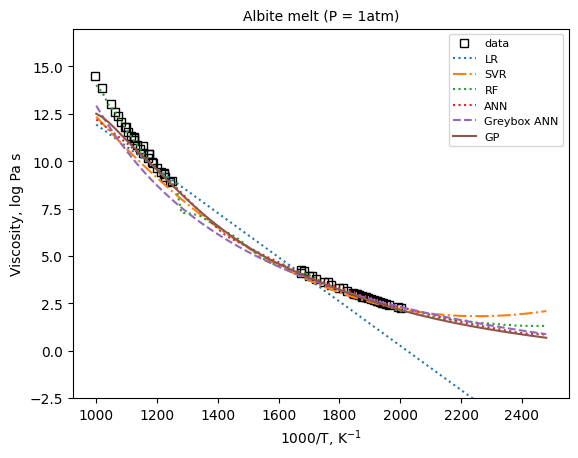

In [9]:
plt.subplot()
plt.title("Albite melt (P = 1atm)", fontsize=10)
plt.plot(dataset_albite["T"], dataset_albite["viscosity"],"ks", markerfacecolor="none", label="data")
for count,i in enumerate(predictions_albite):
    plt.plot(T_interest, i, linestyle=lines[count], label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

(-2.5, 17.0)

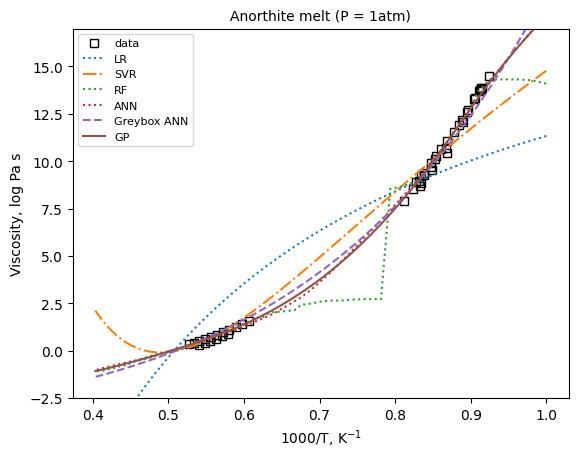

In [8]:
plt.subplot()
plt.title("Anorthite melt (P = 1atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
for count,i in enumerate(predictions_anorthite):
    plt.plot(1000/T_interest, i, linestyle=lines[count], label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

2/2 [==============================] - 0s 2ms/step


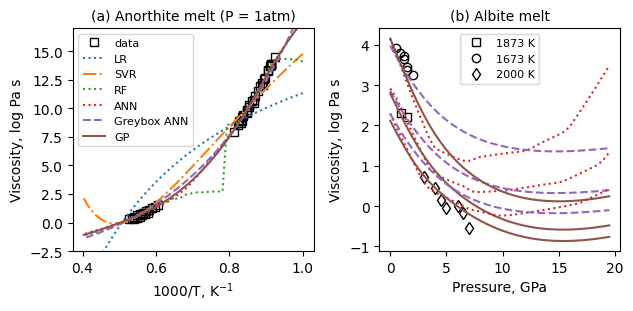

In [6]:
#
# And final figure !
#
lines = [":","-.",":",":","--","-"]
names=["LR","SVR","RF","ANN","Greybox ANN", "GP"]
colors=["C0","C1","C2","C3","C4","C5"]

plt.figure(figsize=(6.44,3.22))

###
# TEMPERATURE SUBPLOT
###
plt.subplot(1,2,1)
plt.title("(a) Anorthite melt (P = 1atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
for count,i in enumerate(predictions_anorthite):
    plt.plot(1000/T_interest, i, linestyle=lines[count], label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

###
# PRESSURE SUBPLOT
###
plt.subplot(1,2,2)
plt.title("(b) Albite melt", fontsize=10)
P_interest = np.arange(0,20.,0.5)

plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==1873,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==1873, "viscosity"], "ks", 
         markerfacecolor="none", label="1873 K")
plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==1673,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==1673, "viscosity"], "ko", 
         markerfacecolor="none", label="1673 K")
plt.plot(dataset_albite_hp.loc[dataset_albite_hp["T"]==2000,"P"], 
         dataset_albite_hp.loc[dataset_albite_hp["T"]==2000, "viscosity"], "kd", 
         markerfacecolor="none", label="2000 K")
plt.legend(fontsize=8)


# Albite dataset
for i in [1873, 1673, 2000]:
    predictions_albite_hp_ = predict_one_compo(dataset_albite_hp.loc[dataset_albite_hp["T"]==i,:], 
                                               ds, models_list, i*np.ones(len(P_interest)), P_interest)

    # we only plot the interesting models
    for j in range(3,len(predictions_albite_hp_)):
        plt.plot(P_interest, predictions_albite_hp_[j], linestyle=lines[j], label=names[j], color=colors[j])

plt.ylabel("Viscosity, log Pa s")
plt.xlabel("Pressure, GPa")
plt.tight_layout()
plt.savefig("./figures/Figure2.pdf")

In [69]:
data_NA = pd.read_excel("./data/database copie.xlsx", sheet_name="Sheet8")

# check composition
data_NA = utils.chimie_control(data_NA).copy()
    
# add descriptors
xi_ = utils.descriptors(data_NA.loc[:, utils.list_oxides()]).values

data_NA_tpx_for_gp = ds.scale_for_gaussianprocess(data_NA.loc[:,"T"].values,
                                                  data_NA.loc[:,"P"].values,
                                                  xi_)

data_NA_tpx_for_rf = ds.scale_for_blackbox(data_NA.loc[:,"T"].values,
                                                  data_NA.loc[:,"P"].values,
                                                  xi_, ds.scaler_tpx)

NA_rf = models_list[2].predict(data_NA_tpx_for_rf)
NA_gp = models_list[5].compiled_predict_y(data_NA_tpx_for_gp)[0]
#predict_one_compo(data_NA, ds, models_list, data_NA.loc[:,"T"].values, data_NA.loc[:,"P"].values) 

In [70]:
NA_rf

array([12.10006711, 12.08228588, 12.04029678, 12.04283664, 12.00398024,
       11.91816555])

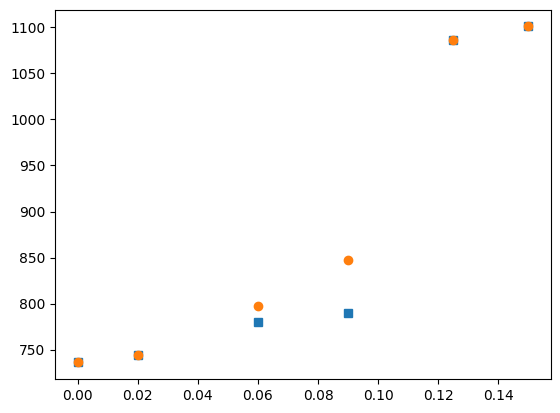

In [71]:
plt.plot(data_NA.al2o3, data_NA.loc[:,"T"],"s")
plt.plot(data_NA.al2o3, data_NA.Tg, "o")

# Figure for presentations

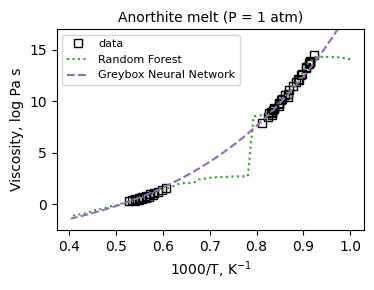

In [72]:
#
# And final figure !
#
lines = [":","-.",":",":","--","-"]
names=["LR","SVR","Random Forest","ANN","Greybox Neural Network", "GP"]
colors=["C0","C1","C2","C3","C4","C5"]

plt.figure(figsize=(4,3))

###
# TEMPERATURE SUBPLOT
###
plt.subplot()
plt.title("Anorthite melt (P = 1 atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
for count in [2,4]:
    plt.plot(1000/T_interest, predictions_anorthite[count], linestyle=lines[count], label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

plt.tight_layout()
plt.savefig("./figures/Figure2a_forpresentations.pdf")

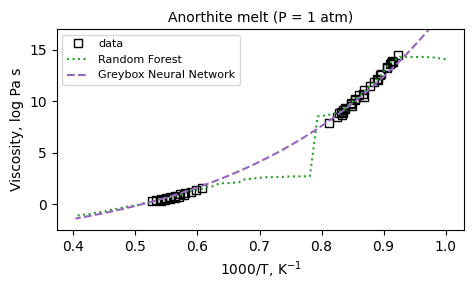

In [73]:
#
# And final figure !
#
lines = [":","-.",":",":","--","-"]
names=["LR","SVR","Random Forest","ANN","Greybox Neural Network", "GP"]
colors=["C0","C1","C2","C3","C4","C5"]

plt.figure(figsize=(5,3))

###
# TEMPERATURE SUBPLOT
###
plt.subplot()
plt.title("Anorthite melt (P = 1 atm)", fontsize=10)
plt.plot(1000/dataset_anorthite["T"], dataset_anorthite["viscosity"],"ks", markerfacecolor="none", label="data")
for count in [2,4]:
    plt.plot(1000/T_interest, predictions_anorthite[count], linestyle=lines[count], label=names[count], color=colors[count])

plt.xlabel("1000/T, K$^{-1}$")
plt.ylabel("Viscosity, log Pa s")
plt.legend(loc="best", fontsize=8)
plt.ylim(-2.5,17)

plt.tight_layout()
plt.savefig("./figures/Figure2b_forpresentations.pdf")

In [112]:
# Comparison with Giordano

import viscopy as vp

dataset_lp = pd.read_excel("./data/database.xlsx", sheet_name="lp")

dataset_lp = vp.chimie_control(dataset_lp)
G2008_preds = vp.viscosity_models.G2008(dataset_lp)

#dataset_test = pd.DataFrame(ds.X_test, columns=ds.X_columns.astype("str"))
#dataset_test["T"] = ds.T_test.copy()
#G2008_preds = vp.viscosity_models.G2008(dataset_test)
GP_preds = models_list[5].compiled_predict_y(ds.scale_for_gaussianprocess(dataset_lp["T"].values.reshape(-1,1), 
                                                                       np.zeros(len(dataset_lp["T"])),
                                                                       dataset_lp.loc[:, ds.X_columns[0:12].astype("str")].values))[0]

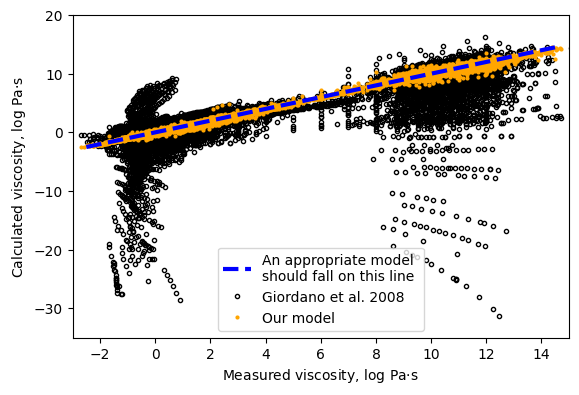

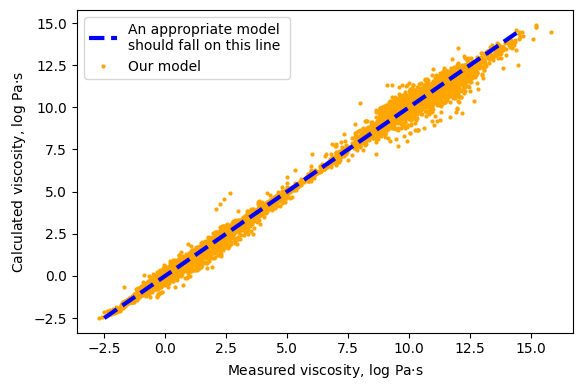

In [136]:
plt.figure(figsize=(6,4))
plt.plot([-2.5,14.5], [-2.5,14.5],"--", color="blue", linewidth=3.0, label="An appropriate model \nshould fall on this line", zorder=2)
plt.legend()

plt.xlabel("Measured viscosity, log Pa$\cdot$s")
plt.ylabel("Calculated viscosity, log Pa$\cdot$s")

plt.tight_layout()
plt.savefig("./figures/Comparison_Giordano_a.pdf")

plt.plot(dataset_lp["viscosity"], G2008_preds[0],".", markerfacecolor="none", markeredgecolor="black", label="Giordano et al. 2008", zorder=0)
plt.xlim(-3,15)
plt.ylim(-35,20)

plt.legend()

plt.savefig("./figures/Comparison_Giordano_b.pdf")

plt.plot(dataset_lp["viscosity"], GP_preds,".", markerfacecolor="orange", markeredgecolor="none", label="Our model", zorder=1)
plt.legend()
plt.savefig("./figures/Comparison_Giordano_c.pdf")

plt.figure(figsize=(6,4))
plt.plot([-2.5,14.5], [-2.5,14.5],"--", color="blue", linewidth=3.0, label="An appropriate model \nshould fall on this line", zorder=2)
plt.legend()

plt.xlabel("Measured viscosity, log Pa$\cdot$s")
plt.ylabel("Calculated viscosity, log Pa$\cdot$s")

plt.tight_layout()
plt.plot(dataset_lp["viscosity"], GP_preds,".", markerfacecolor="orange", markeredgecolor="none", label="Our model", zorder=1)
plt.legend()
plt.savefig("./figures/Comparison_Giordano_d.pdf")


In [7]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import utils as utils
import deepmelt as imelt

import xgboost as xgb

# import sklearn models
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import torch

# import joblib (save and load models)
from joblib import dump, load

#
# First we check if CUDA is available
#
device = utils.get_default_device()

ModuleNotFoundError: No module named 'utils'

In [2]:
# Loading data used to train the models

print("Loading the viscosity datasets...")
ds = imelt.data_loader(path_viscosity='./all_viscosity.hdf5')
ds.print_data()
print("Loaded.")

# Concatenate the X datasets
X_train = ds.x_visco_train.detach().numpy()
X_valid = ds.x_visco_valid.detach().numpy()
X_test = ds.x_visco_test.detach().numpy()

y_train = ds.y_visco_train.detach().numpy()
y_valid = ds.y_visco_valid.detach().numpy()
y_test = ds.y_visco_test.detach().numpy()

T_train = ds.T_visco_train.numpy()
T_valid = ds.T_visco_valid.numpy()
T_test = ds.T_visco_test.numpy()

P_train = ds.P_visco_train.numpy()
P_valid = ds.P_visco_valid.numpy()
P_test  = ds.P_visco_test.numpy()

# Load transformed data (centered and scaled)
X_train_T = load('./models/X_train_T.joblib')
X_valid_T = load('./models/X_valid_T.joblib')
X_test_T = load('./models/X_test_T.joblib')
# Load transformed data (centered and scaled)
X_train_P = load('./models/X_train_P.joblib')
X_valid_P = load('./models/X_valid_P.joblib')
X_test_P = load('./models/X_test_P.joblib')



Loading the viscosity datasets...
################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 2912
Number of unique compositions in training (viscosity): 2258
Dataset separations are 0.78 in train, 0.11 in valid, 0.11 in test

Number of unique compositions (entropy): 99
Number of unique compositions in training (entropy): 79
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

This is for checking the shape consistency of the dataset:

Visco train shape
torch.Size([11767, 155])
torch.Size([11767, 1])
torch.Size([11767, 1])
Entropy train shape
torch.Size([79, 155])
torch.Size([79, 1])
Loaded.


In [3]:
# Loading previously trained models

#Linear Regression
clf_linreg = load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = load('./models/clf_nn.joblib')

# XGBOOST Random Forest Regressor
clf_xgb = load('./models/clf_xgb.joblib')

# Greybox Neural Network
model = tf.keras.models.load_model('./bestBEST.keras')

# Loading ivisc
import ivisc
neuralmodel = ivisc.ivisc(ds.x_visco_train.shape[1],
                          hidden_size=[400,400,400,400],
                          activation_function = torch.nn.GELU(), # activation units in FFN
                          shape = "rectangle")

name = './model/l4_n[400, 400, 400, 400]_p0.1_GELU_cpfree.pth'
neuralmodel.load_state_dict(torch.load(name, map_location=device))
neuralmodel.eval()    

print('Loaded.')

Loaded.


In [4]:
# Linear Regression Evaluation
y_train_clf_linreg = clf_linreg.predict(X_train_T)
y_valid_clf_linreg = clf_linreg.predict(X_valid_T)
y_test_clf_linreg = clf_linreg.predict(X_test_T)

linreg_mse_train = mean_squared_error(y_train, y_train_clf_linreg, squared=False)
linreg_mse_valid = mean_squared_error(y_valid, y_valid_clf_linreg, squared=False)
linreg_mse_test = mean_squared_error(y_test, y_test_clf_linreg, squared=False)

linreg_r2_train = r2_score(y_train, y_train_clf_linreg)
linreg_r2_valid = r2_score(y_valid, y_valid_clf_linreg)
linreg_r2_test = r2_score(y_test, y_test_clf_linreg)

# Support Vector Machine Regression Evaluation
y_train_clf_svr = clf_svr.predict(X_train_T)
y_valid_clf_svr = clf_svr.predict(X_valid_T)
y_test_clf_svr = clf_svr.predict(X_test_T)

svr_mse_train = mean_squared_error(y_train, y_train_clf_svr, squared=False)
svr_mse_valid = mean_squared_error(y_valid, y_valid_clf_svr, squared=False)
svr_mse_test = mean_squared_error(y_test, y_test_clf_svr, squared=False)

svr_r2_train = r2_score(y_train, y_train_clf_svr)
svr_r2_valid = r2_score(y_valid, y_valid_clf_svr)
svr_r2_test = r2_score(y_test, y_test_clf_svr)

# Artificial Neural Network Evaluation
y_train_clf_nn = clf_nn.predict(X_train_T)
y_valid_clf_nn = clf_nn.predict(X_valid_T)
y_test_clf_nn = clf_nn.predict(X_test_T)

nn_mse_train = mean_squared_error(y_train, y_train_clf_nn, squared=False)
nn_mse_valid = mean_squared_error(y_valid, y_valid_clf_nn, squared=False)
nn_mse_test = mean_squared_error(y_test, y_test_clf_nn, squared=False)

nn_r2_train = r2_score(y_train, y_train_clf_nn)
nn_r2_valid = r2_score(y_valid, y_valid_clf_nn)
nn_r2_test = r2_score(y_test, y_test_clf_nn)

# Random Forest Regressor Evaluation
y_train_clf_xgb = clf_xgb.predict(X_train_T)
y_valid_clf_xgb = clf_xgb.predict(X_valid_T)
y_test_clf_xgb = clf_xgb.predict(X_test_T)

xgb_mse_train = mean_squared_error(y_train, y_train_clf_xgb, squared=False)
xgb_mse_valid = mean_squared_error(y_valid, y_valid_clf_xgb, squared=False)
xgb_mse_test = mean_squared_error(y_test, y_test_clf_xgb, squared=False)

xgb_r2_train = r2_score(y_train, y_train_clf_xgb)
xgb_r2_valid = r2_score(y_valid, y_valid_clf_xgb)
xgb_r2_test = r2_score(y_test, y_test_clf_xgb)

# Greybox model evaluation
y_train_model = model.predict((X_train_P,T_train))
y_valid_model = model.predict((X_valid_P,T_valid))
y_test_model = model.predict((X_test_P,T_test))

model_mse_train = mean_squared_error(y_train, y_train_model+6.25, squared=False)
model_mse_valid = mean_squared_error(y_valid, y_valid_model+6.25, squared=False)
model_mse_test = mean_squared_error(y_test, y_test_model+6.25, squared=False)

model_r2_train = r2_score(y_train, y_train_model+6.25)
model_r2_valid = r2_score(y_valid, y_valid_model+6.25)
model_r2_test = r2_score(y_test, y_test_model+6.25)

# i-visc model evaluation
y_train_ivisc = neuralmodel.predict(ds.x_visco_train,ds.T_visco_train,ds.P_visco_train).detach().numpy()
y_valid_ivisc = neuralmodel.predict(ds.x_visco_valid,ds.T_visco_valid,ds.P_visco_valid).detach().numpy()
y_test_ivisc = neuralmodel.predict(ds.x_visco_test,ds.T_visco_test,ds.P_visco_test).detach().numpy()

ivisc_mse_train = mean_squared_error(y_train,y_train_ivisc, squared=False)
ivisc_mse_valid = mean_squared_error(y_valid,y_valid_ivisc, squared=False)
ivisc_mse_test = mean_squared_error(y_test,y_test_ivisc, squared=False)

ivisc_r2_train = r2_score(y_train,y_train_ivisc)
ivisc_r2_valid = r2_score(y_valid,y_valid_ivisc)
ivisc_r2_test = r2_score(y_test,y_test_ivisc)

53/53 [==============================] - 0s 1ms/step


In [5]:
# Stats data for all regressions

# Linear regression
print('Linear Regression\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % linreg_mse_train,'\n',
      ' Valid    %.2f' % linreg_mse_valid,'\n',
      ' Test     %.2f' % linreg_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % linreg_r2_train,'\n',
      ' Valid    %.2f' % linreg_r2_valid,'\n',
      ' Test     %.2f' % linreg_r2_test,'\n'
     )
# Support Vector Machine Regression
print('Support Vector Machine Regression','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % svr_mse_train,'\n',
      ' Valid    %.2f' % svr_mse_valid,'\n',
      ' Test     %.2f' % svr_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % svr_r2_train,'\n',
      ' Valid    %.2f' % svr_r2_valid,'\n',
      ' Test     %.2f' % svr_r2_test,'\n'
     )
# Random Forest Regressor 
print('Random Forest Regressor','\n','Root Mean Square Errors:','\n',
      ' Train    %.2f' % xgb_mse_train,'\n',
      ' Valid    %.2f' % xgb_mse_valid,'\n',
      ' Test     %.2f' % xgb_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % xgb_r2_train,'\n',
      ' Valid    %.2f' % xgb_r2_valid,'\n',
      ' Test     %.2f' % xgb_r2_test,'\n'
     )
# Artificial Neural Network
print('Artificial Neural Network','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % nn_mse_train,'\n',
      ' Valid    %.2f' % nn_mse_valid,'\n',
      ' Test     %.2f' % nn_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % nn_r2_train,'\n',
      ' Valid    %.2f' % nn_r2_valid,'\n',
      ' Test     %.2f' % nn_r2_test,'\n'
     )
# Greybox model evaluation
print('Greybox Model','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % model_mse_train,'\n',
      ' Valid    %.2f' % model_mse_valid,'\n',
      ' Test     %.2f' % model_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % model_r2_train,'\n',
      ' Valid    %.2f' % model_r2_valid,'\n',
      ' Test     %.2f' % model_r2_test,'\n'
     )
# i-visc model evaluation
print('i-visc Greybox Model','\n',
      'Root Mean Square Errors:','\n',
      ' Train    %.2f' % ivisc_mse_train,'\n',
      ' Valid    %.2f' % ivisc_mse_valid,'\n',
      ' Test     %.2f' % ivisc_mse_test,'\n'
      ' Coefficient of Determination:','\n',
      ' Train    %.2f' % ivisc_r2_train,'\n',
      ' Valid    %.2f' % ivisc_r2_valid,'\n',
      ' Test     %.2f' % ivisc_r2_test,'\n'
     )

Linear Regression
 Root Mean Square Errors: 
  Train    1.19 
  Valid    1.45 
  Test     1.23 
 Coefficient of Determination: 
  Train    0.94 
  Valid    0.91 
  Test     0.93 

Support Vector Machine Regression 
 Root Mean Square Errors: 
  Train    0.44 
  Valid    0.38 
  Test     1.49 
 Coefficient of Determination: 
  Train    0.99 
  Valid    0.99 
  Test     0.90 

Random Forest Regressor 
 Root Mean Square Errors: 
  Train    0.12 
  Valid    0.59 
  Test     0.46 
 Coefficient of Determination: 
  Train    1.00 
  Valid    0.99 
  Test     0.99 

Artificial Neural Network 
 Root Mean Square Errors: 
  Train    0.29 
  Valid    0.27 
  Test     0.56 
 Coefficient of Determination: 
  Train    1.00 
  Valid    1.00 
  Test     0.99 

Greybox Model 
 Root Mean Square Errors: 
  Train    0.33 
  Valid    0.52 
  Test     0.64 
 Coefficient of Determination: 
  Train    1.00 
  Valid    0.99 
  Test     0.98 

i-visc Greybox Model 
 Root Mean Square Errors: 
  Train    0.46 
  Va

([<matplotlib.axis.YTick at 0x132da5490>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

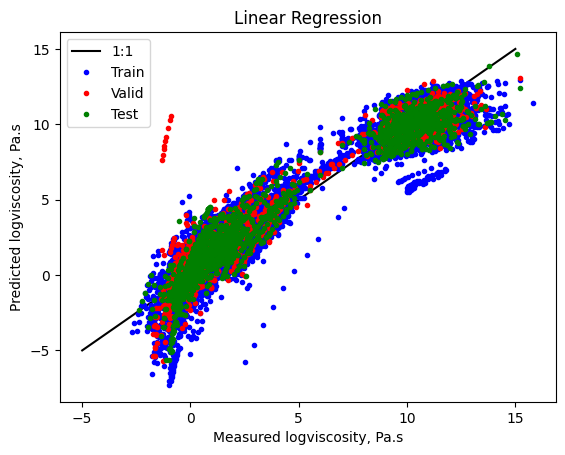

In [6]:
# Linear Regression
plt.plot([-5,15],[-5,15],'k')
plt.plot(y_train,y_train_clf_linreg,'b.')
plt.plot(y_valid,y_valid_clf_linreg,'r.')
plt.plot(y_test,y_test_clf_linreg,'g.')
plt.xlabel('Measured logviscosity, Pa.s')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.title('Linear Regression')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

([<matplotlib.axis.YTick at 0x1337dd4d0>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

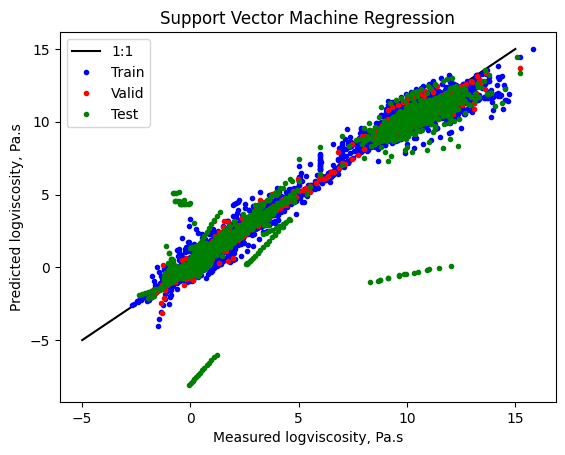

In [7]:
# Support Vector Machine Regression
plt.plot([-5,15],[-5,15],'k')
plt.plot(y_train,y_train_clf_svr,'b.')
plt.plot(y_valid,y_valid_clf_svr,'r.')
plt.plot(y_test,y_test_clf_svr,'g.')
plt.xlabel('Measured logviscosity, Pa.s')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.title('Support Vector Machine Regression')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

([<matplotlib.axis.YTick at 0x13384bc90>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

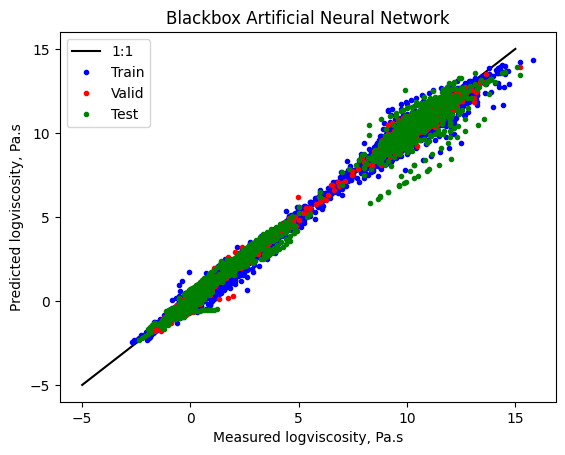

In [8]:
# Artificial Neural Network
plt.plot([-5,15],[-5,15],'k')
plt.plot(y_train,y_train_clf_nn,'b.')
plt.plot(y_valid,y_valid_clf_nn,'r.')
plt.plot(y_test,y_test_clf_nn,'g.')
plt.xlabel('Measured logviscosity, Pa.s')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.title('Blackbox Artificial Neural Network')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

([<matplotlib.axis.YTick at 0x132dc4d10>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

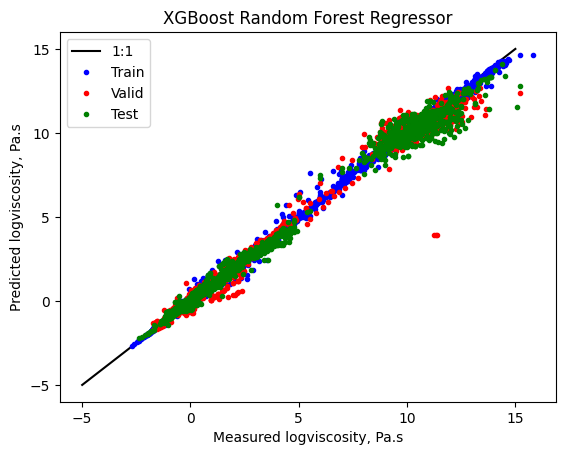

In [9]:
# Random Forest Regressor
plt.plot([-5,15],[-5,15],'k')
plt.plot(y_train,y_train_clf_xgb,'b.')
plt.plot(y_valid,y_valid_clf_xgb,'r.')
plt.plot(y_test,y_test_clf_xgb,'g.')
plt.xlabel('Measured logviscosity, Pa.s')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.title('XGBoost Random Forest Regressor')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

([<matplotlib.axis.YTick at 0x133958510>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

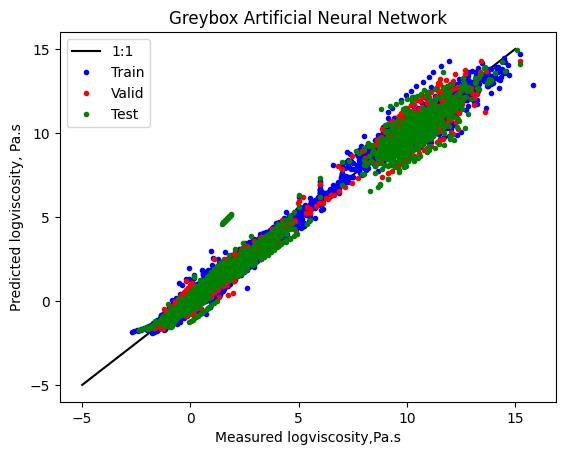

In [10]:
# Greybox model
plt.plot([-5,15],[-5,15],'k')
plt.plot(y_train, y_train_model+6.25,'b.')
plt.plot(y_valid, y_valid_model+6.25,'r.')
plt.plot(y_test, y_test_model+6.25,'g.')
plt.title('Greybox Artificial Neural Network')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.xlabel('Measured logviscosity,Pa.s')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

([<matplotlib.axis.YTick at 0x132e1cc10>,
 [Text(0, -5, '−5'),
  Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15')])

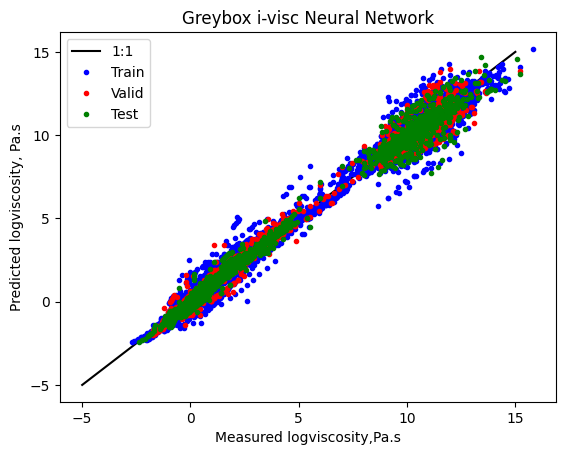

In [11]:
# i-visc Greybox model
plt.plot([-5,15],[-5,15],'k')
plt.plot(ds.y_visco_train, y_train_ivisc,'b.')
plt.plot(ds.y_visco_valid, y_valid_ivisc,'r.')
plt.plot(ds.y_visco_test, y_test_ivisc,'g.')
plt.title('Greybox i-visc Neural Network')
plt.ylabel('Predicted logviscosity, Pa.s')
plt.xlabel('Measured logviscosity,Pa.s')
plt.legend(['1:1','Train','Valid','Test'])
plt.yticks(np.arange(-5,20,5))

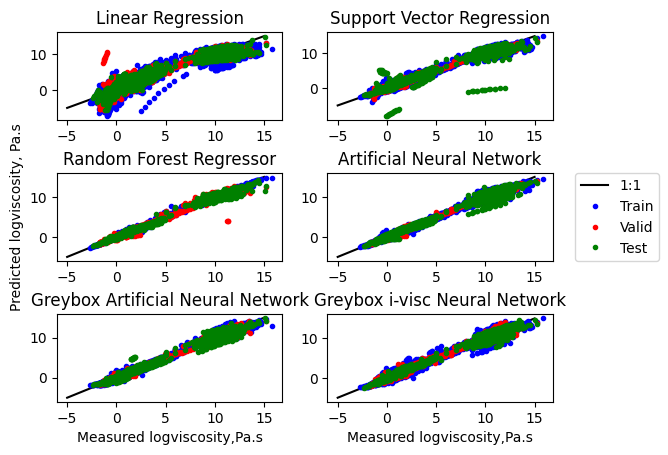

In [12]:
# All graphs together for better comparaison
ax_lin = plt.subplot(3,2,1)
ax_svr = plt.subplot(3,2,2)
ax_xgb = plt.subplot(3,2,3)
ax_nn = plt.subplot(3,2,4)
ax_grey = plt.subplot(3,2,5)
ax_ivisc = plt.subplot(3,2,6)

ax_lin.plot([-5,15],[-5,15],'k')
ax_lin.plot(y_train,y_train_clf_linreg,'b.')
ax_lin.plot(y_valid,y_valid_clf_linreg,'r.')
ax_lin.plot(y_test,y_test_clf_linreg,'g.')
ax_lin.set_title('Linear Regression')

ax_svr.plot([-5,15],[-5,15],'k')
ax_svr.plot(y_train,y_train_clf_svr,'b.')
ax_svr.plot(y_valid,y_valid_clf_svr,'r.')
ax_svr.plot(y_test,y_test_clf_svr,'g.')
ax_svr.set_title('Support Vector Regression')

ax_xgb.plot([-5,15],[-5,15],'k')
ax_xgb.plot(y_train,y_train_clf_xgb,'b.')
ax_xgb.plot(y_valid,y_valid_clf_xgb,'r.')
ax_xgb.plot(y_test,y_test_clf_xgb,'g.')
ax_xgb.set_ylabel('Predicted logviscosity, Pa.s')
ax_xgb.set_title('Random Forest Regressor')

ax_nn.plot([-5,15],[-5,15],'k')
ax_nn.plot(y_train,y_train_clf_nn,'b.')
ax_nn.plot(y_valid,y_valid_clf_nn,'r.')
ax_nn.plot(y_test,y_test_clf_nn,'g.')
ax_nn.set_title('Artificial Neural Network')

ax_grey.plot([-5,15],[-5,15],'k')
ax_grey.plot(y_train, y_train_model+6.25,'b.')
ax_grey.plot(y_valid, y_valid_model+6.25,'r.')
ax_grey.plot(y_test, y_test_model+6.25,'g.')
ax_grey.set_title('Greybox Artificial Neural Network')
ax_grey.set_xlabel('Measured logviscosity,Pa.s')

ax_ivisc.plot([-5,15],[-5,15],'k')
ax_ivisc.plot(ds.y_visco_train, y_train_ivisc,'b.')
ax_ivisc.plot(ds.y_visco_valid, y_valid_ivisc,'r.')
ax_ivisc.plot(ds.y_visco_test, y_test_ivisc,'g.')
ax_ivisc.set_title('Greybox i-visc Neural Network')
ax_ivisc.set_xlabel('Measured logviscosity,Pa.s')

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.legend(['1:1','Train','Valid','Test'],loc='center right',bbox_to_anchor=[1.5,2.1])

# Prediction for one composition

We compare the blackbox models for the prediction of the viscosity of a given composition

In [13]:
# initial data import

dataset_lp = pd.read_excel("./database.xlsx", sheet_name="lp")
dataset_hp = pd.read_excel("./database.xlsx", sheet_name="hp")

std = load('./models/ScalerT.joblib')
std2 = load('./models/ScalerP.joblib')

/usr/local/Caskroom/miniconda/base/envs/pyt/lib/python3.11/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


4/4 [==============================] - 0s 2ms/step
Number of data = 52


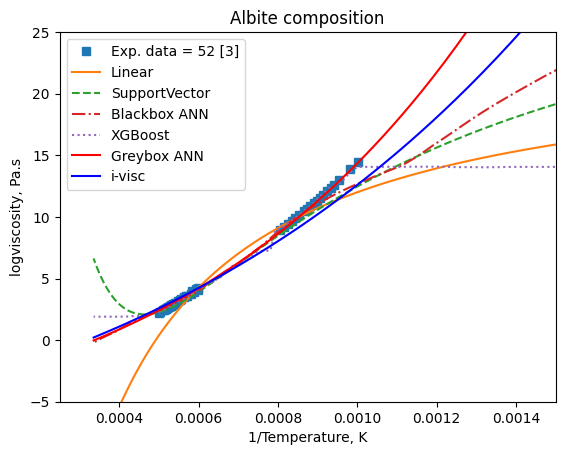

In [14]:
# Composition Albite NAK75_12_0 LL2013

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="NAK75_12_0")|
                     (dataset_lp.Name_publi=="Ab"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 52 [3]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Albite composition')
#secax = plt.subplot().secondary_xaxis('top')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 68


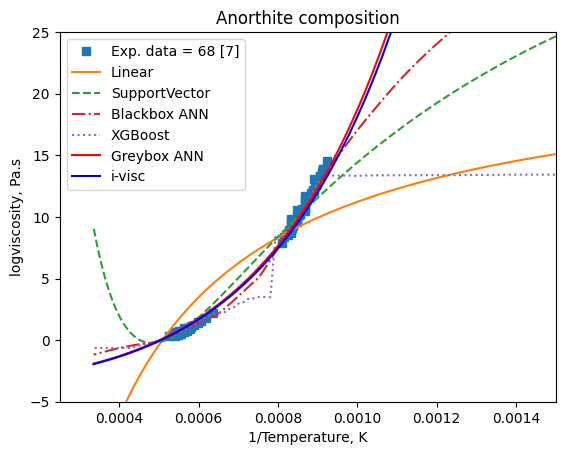

In [15]:
# Composition Anorthite Scarfe et al 1983

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="Anorthite")|
                     (dataset_lp.Name_publi=="An100")|
                     (dataset_lp.Name_publi=="an100")|
                     (dataset_lp.Name_publi=="An"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 68 [7]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Anorthite composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 76


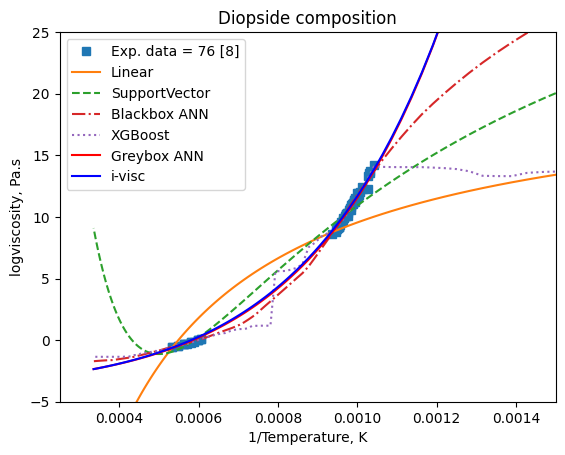

In [16]:
# Composition peridotide

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="Diopside")|
                     (dataset_lp.Name_publi=="di100")|
                     (dataset_lp.Name_publi=="Di"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 76 [8]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Diopside composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 27


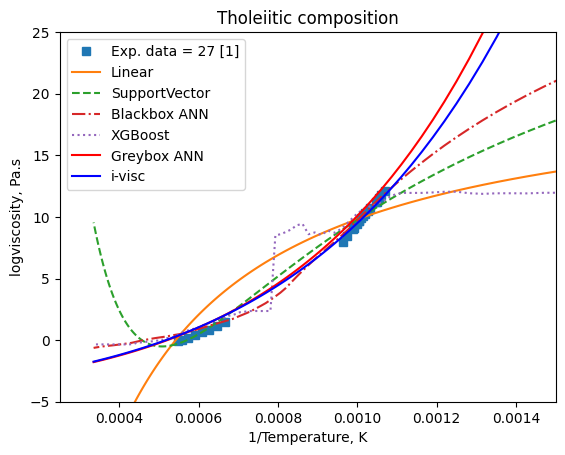

In [17]:
# Composition tholeiitic melt 
#Remelted continental rift basalt erupted 2002, Mt. Nyiragongo, DR of Congo

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="NYI")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 27 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Tholeiitic composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 27


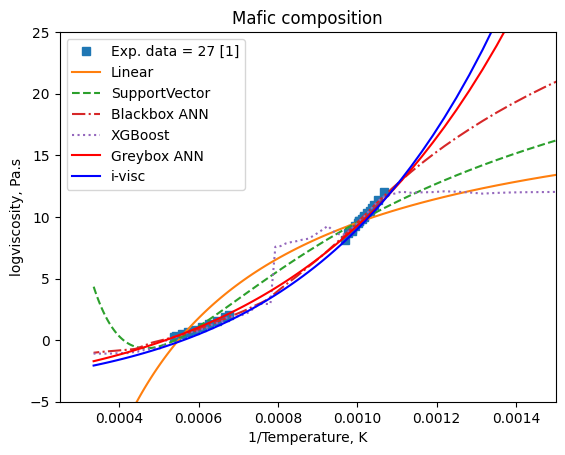

In [18]:
# Composition mafic melt 
# Remelted continental flood basalt, Chengwatana, WI

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="CHW")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 27 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Mafic composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 23


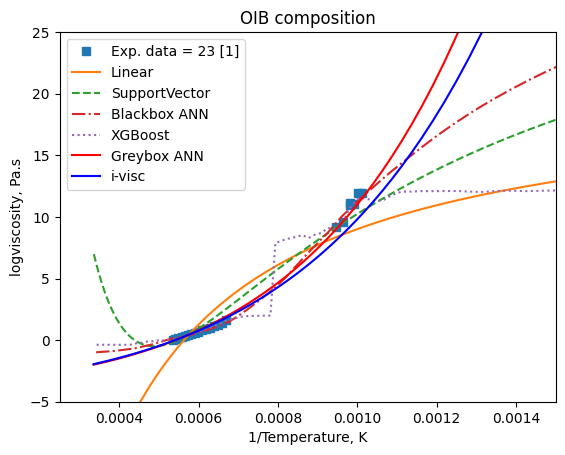

In [19]:
# Composition OIB melt 
# Remelted OIB, Mauna Ulu, Kilauea, HI

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="MU-Fe")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 23 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('OIB composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 11


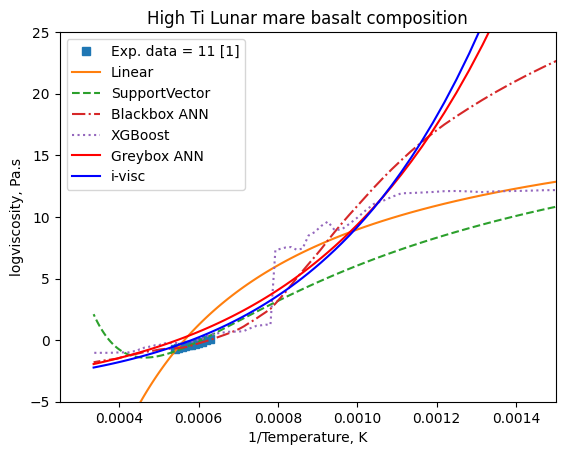

In [20]:
# Composition MOON melt 
# Synth. high-Ti lunar mare basalt

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="LM")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 11 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('High Ti Lunar mare basalt composition')
print('Number of data =',di_.shape[0])

4/4 [==============================] - 0s 2ms/step
Number of data = 30


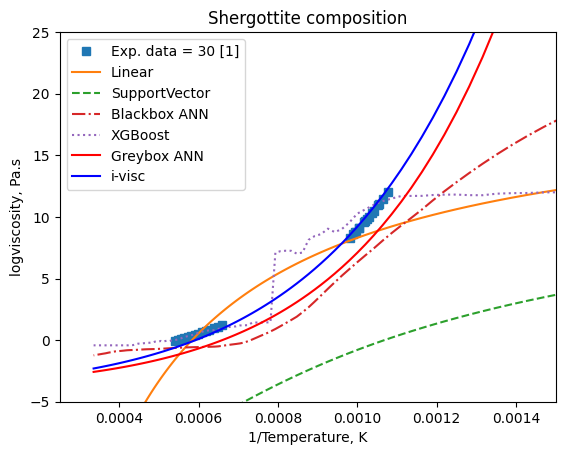

In [21]:
# Composition Mars melt 
# Shergottite Mars composition

# loading data of interest
di_ = dataset_lp.loc[(dataset_lp.Name_publi=="SHG")&
                     (dataset_lp.ref=="Sehlke and Whittington 2016"),:].reset_index()

# add descriptors
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]/100).values

# temperature axis for interpolation
T_interest = np.arange(500, 3000, 20.)

# pressure axis for interpolation
P_interest = np.zeros(len(T_interest))

# same composition so we get first line, then create an array with interesting temps
xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

# transformation
xi_s = np.concatenate((T_interest.reshape(-1,1),
                            P_interest.reshape(-1,1),
                            xi),axis=1)

xi_grey = np.concatenate((  P_interest.reshape(-1,1),
                            xi),axis=1)

# predictions 
oneC_lin = clf_linreg.predict(std.transform(xi_s))
oneC_svr = clf_svr.predict(std.transform(xi_s))
oneC_nn = clf_nn.predict(std.transform(xi_s))
oneC_xgb = clf_xgb.predict(std.transform(xi_s))
oneC_grey = model.predict((std2.transform(xi_grey), T_interest.reshape(-1,1)))
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(xi),
                                 torch.FloatTensor(T_interest).reshape(-1,1),
                                 torch.FloatTensor(P_interest).reshape(-1,1))

# figure
plt.figure()
plt.plot(1/di_.loc[:,"T"], di_.viscosity,"s",label="Exp. data = 30 [1]")
plt.plot(1/T_interest, oneC_lin,"-",label="Linear")
plt.plot(1/T_interest, oneC_svr,"--",label="SupportVector")
plt.plot(1/T_interest, oneC_nn,"-.",label="Blackbox ANN")
plt.plot(1/T_interest, oneC_xgb,":", label="XGBoost")
plt.plot(1/T_interest, oneC_grey+6.25,"r-", label="Greybox ANN")
plt.plot(1/T_interest, oneC_ivisc.detach().numpy(),"b-", label="i-visc")
plt.legend(loc='best')
plt.ylim(-5,25)
plt.xlim(0.00025,0.0015)
plt.xlabel('1/Temperature, K')
plt.ylabel('logviscosity, Pa.s')
plt.title('Shergottite composition')
print('Number of data =',di_.shape[0])

# Prediction for one composition with Pressure

In [22]:
testcompo = pd.read_excel('./TestsCompo.xlsx', sheet_name='casio3P')
testcompo.head()

,P,T,sio2,tio2,al2o3,feo,fe2o3,mno,na2o,k2o,mgo,cao,p2o5,h2o,reference,Compo
0,1,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
1,2,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
2,3,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
3,4,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3
4,5,1600,0.478452,0,0.0035,0.0006,0,0,0,0,0.0013,0.469153,0,0.046995,Cochain et al. 2017,CaSiO3


In [23]:
X_compo = utils.descriptors(testcompo.loc[:,utils.list_oxides()]).values
T_compo = testcompo['T'].values
P_compo = testcompo['P'].values
#y_compo = testcompo['y'].values
#other_compo = pd.concat([testcompo['reference'],testcompo['Name'],testcompo['Compo']], axis=1)
X_compo_PT = np.concatenate((T_compo.reshape(-1,1), P_compo.reshape(-1,1), X_compo),axis=1)
X_compo_grey = np.concatenate((P_compo.reshape(-1,1), X_compo),axis=1)


In [24]:
onePC_lin = clf_linreg.predict(std.transform(X_compo_PT))
onePC_svr = clf_svr.predict(std.transform(X_compo_PT))
onePC_nn = clf_nn.predict(std.transform(X_compo_PT))
onePC_xgb = clf_xgb.predict(std.transform(X_compo_PT))
onePC_grey = model.predict((std2.transform(X_compo_grey), T_compo.reshape(-1,1)))
onePC_ivisc = neuralmodel.predict(torch.FloatTensor(X_compo),
                                  torch.FloatTensor(T_compo).reshape(-1,1),
                                  torch.FloatTensor(P_compo).reshape(-1,1)).detach().numpy()

2/2 [==============================] - 0s 3ms/step


In [25]:
expdata = dataset_hp.loc[dataset_hp.Name_publi=="CaSiO3",:].reset_index()
expdata

,index,Name,sio2,tio2,al2o3,feo,fe2o3,mno,mgo,cao,...,P,T,viscosity,Sc,ref,Name_publi,Date Update,System,LineNumber,Compo_interest
0,0,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,1.1,1873,-0.73,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
1,1,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,1.8,1883,-0.78,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
2,2,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,3.4,1973,-0.80,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
3,3,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,4.3,1913,-0.93,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
4,4,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,5.9,2173,-0.96,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
5,5,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.1,2008,-1.00,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
6,6,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.4,2128,-0.98,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN
7,7,staffmnkmcph_47.9_0_0.4_0.1_0_0_0.1_46.9_0_0_0...,47.85,0.0,0.35,0.06,0.0,0.0,0.13,46.92,...,6.8,2061,-0.99,NaN,Cochain et al. 2017,CaSiO3,NaN,NaN,NaN,NaN


Number of data = 8


Text(0.5, 0, 'Pressure, GPa')

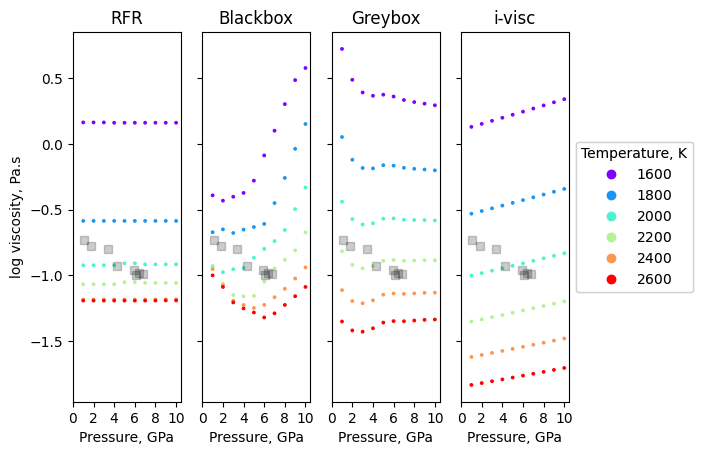

In [26]:
fig=plt.figure()
ax1=plt.subplot(141)
ax2=plt.subplot(142,sharey=ax1,sharex=ax1)
ax3=plt.subplot(143,sharey=ax2,sharex=ax1)
ax4=plt.subplot(144,sharey=ax3,sharex=ax1)
ax1.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax1.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax2.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax2.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax3.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax3.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)
ax4.plot(expdata['P'],expdata['viscosity'],'ks',alpha=0.2)
#ax4.errorbar(expdata['P'],expdata['viscosity'],0.5,ecolor='black',alpha=0.2)

#plt.plot(di3_.loc[:,"P"], di3_.viscosity,"s",label="Data")
#plt.plot(P_compo, onePC_lin,"-",label="Linear")
#plt.plot(P_compo, onePC_svr,"--",label="SupportVector")
ax1.scatter(P_compo, onePC_xgb,cmap='rainbow',c=T_compo,s=3)
ax2.scatter(P_compo, onePC_nn,cmap='rainbow',c=T_compo,s=3)
ax3.scatter(P_compo, onePC_grey+6.25,cmap='rainbow',c=T_compo,s=3)
Tlegend = ax4.scatter(P_compo, onePC_ivisc,cmap='rainbow',c=T_compo,s=3)
#plt.legend(['1600', '1800', '2000', '2400', '2600'],loc='best')
#plt.ylim(-5,4)
#plt.xlim(0,10)
ax1.set_title('RFR')
ax2.set_title('Blackbox')
ax3.set_title('Greybox')
ax4.set_title('i-visc')
print('Number of data =',expdata.shape[0])
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
ax1.set_ylabel('log viscosity, Pa.s')
#fig.add_artist()
#fig.set_figwidth(7)
# produce a legend with the unique colors from the scatter
legend = ax4.legend(*Tlegend.legend_elements(),
                    loc="center left", bbox_to_anchor=(1,0.5), title="Temperature, K")
fig.add_artist(legend)
ax1.set_xticks(np.arange(0,11,2))
ax1.set_xlabel('Pressure, GPa')
ax2.set_xlabel('Pressure, GPa')
ax3.set_xlabel('Pressure, GPa')
ax4.set_xlabel('Pressure, GPa')

# onecompo - All models comparaison with ivisc

In [27]:
testperidot = pd.read_excel('./TestsCompo.xlsx', sheet_name='peridotite_2')
X_peridot = utils.descriptors(testperidot.loc[:,utils.list_oxides()]).values
T_peridot = testperidot['T'].values
P_peridot = testperidot['P'].values
X_peridot_PT = np.concatenate((T_peridot.reshape(-1,1), P_peridot.reshape(-1,1), X_peridot),axis=1)
X_peridot_grey = np.concatenate((P_peridot.reshape(-1,1), X_peridot),axis=1)


In [46]:
datatestperidot = pd.read_excel('./TestsCompo.xlsx', sheet_name='Data')
# loading data of interest
di_ = datatestperidot.loc[(datatestperidot.Compo=="Peridotite")|
                          (datatestperidot.Compo=="Peridotite_2"),:].reset_index()

dataX_peridot = utils.descriptors(di_.loc[:,utils.list_oxides()]).values
dataT_peridot = di_['T'].values
dataP_peridot = di_['P'].values
dataX_peridot_PT = np.concatenate((dataT_peridot.reshape(-1,1), dataP_peridot.reshape(-1,1), dataX_peridot),axis=1)
dataX_peridot_grey = np.concatenate((dataP_peridot.reshape(-1,1), dataX_peridot),axis=1)


In [45]:
dataP_peridot

array([], dtype=float64)

In [28]:
peridot_lin = clf_linreg.predict(std.transform(X_peridot_PT))
peridot_svr = clf_svr.predict(std.transform(X_peridot_PT))
peridot_nn = clf_nn.predict(std.transform(X_peridot_PT))
peridot_xgb = clf_xgb.predict(std.transform(X_peridot_PT))
peridot_grey = model.predict((std2.transform(X_peridot_grey), T_peridot.reshape(-1,1)))
peridot_ivisc = neuralmodel.predict(torch.FloatTensor(X_peridot),
                                 torch.FloatTensor(T_peridot).reshape(-1,1),
                                 torch.FloatTensor(P_peridot).reshape(-1,1))


2/2 [==============================] - 0s 3ms/step


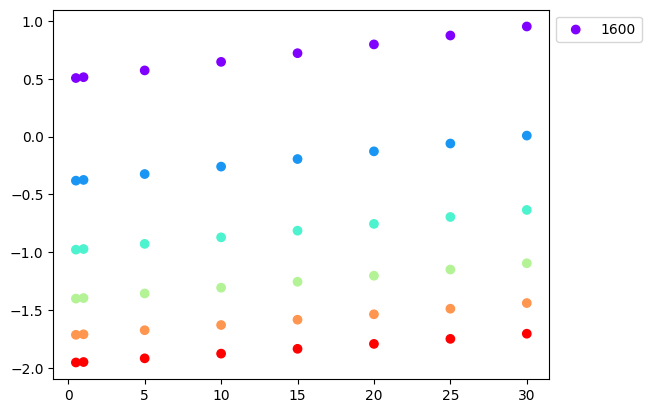

In [29]:
plt.scatter(P_peridot,peridot_ivisc.detach().numpy(),cmap='rainbow',c=T_peridot)
plt.legend(T_peridot,bbox_to_anchor=(1,1))

''

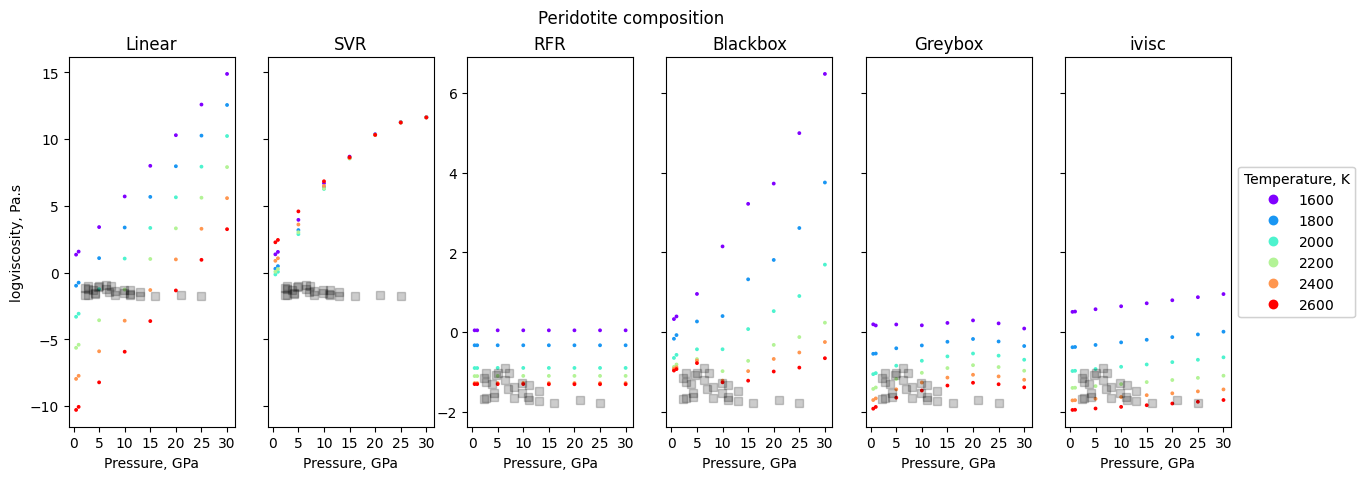

In [50]:
fig=plt.figure()
ax1=plt.subplot(161)
ax2=plt.subplot(162,sharey=ax1)
ax3=plt.subplot(163)
ax4=plt.subplot(164,sharey=ax3)
ax5=plt.subplot(165,sharey=ax4)
ax6=plt.subplot(166,sharey=ax5)
#ax1.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
#ax2.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
#ax3.plot(albite['P'],albite['viscosity'],'ks',alpha=0.2)
    
#plt.plot(di3_.loc[:,"P"], di3_.viscosity,"s",label="Data")
#plt.plot(P_compo, onePC_lin,"-",label="Linear")
#plt.plot(P_compo, onePC_svr,"--",label="SupportVector")
ax1.scatter(P_peridot, peridot_lin,cmap='rainbow',c=T_peridot,s=3)
ax2.scatter(P_peridot, peridot_svr,cmap='rainbow',c=T_peridot,s=3)
ax3.scatter(P_peridot, peridot_xgb,cmap='rainbow',c=T_peridot,s=3)
ax4.scatter(P_peridot, peridot_nn,cmap='rainbow',c=T_peridot,s=3)
ax5.scatter(P_peridot, peridot_grey+6.25,cmap='rainbow',c=T_peridot,s=3)
Tlegend = ax6.scatter(P_peridot, peridot_ivisc.detach().numpy(),cmap='rainbow',c=T_peridot,s=3)

#plt.legend(['1600', '1800', '2000', '2400', '2600'],loc='best')
#plt.ylim(-5,4)
#plt.xlim(0.00025,0.001)
ax1.set_title('Linear')
ax2.set_title('SVR')
ax3.set_title('RFR')
ax4.set_title('Blackbox')
ax5.set_title('Greybox')
ax6.set_title('ivisc')
#print('Number of data =',testcompo.shape[0])
plt.suptitle('Peridotite composition')
ax1.set_ylabel('logviscosity, Pa.s')
ax1.set_xlabel('Pressure, GPa')
ax2.set_xlabel('Pressure, GPa')
ax3.set_xlabel('Pressure, GPa')
ax4.set_xlabel('Pressure, GPa')
ax5.set_xlabel('Pressure, GPa')
ax6.set_xlabel('Pressure, GPa')
ax1.set_xticks([0,5,10,15,20,25,30])
ax2.set_xticks([0,5,10,15,20,25,30])
ax3.set_xticks([0,5,10,15,20,25,30])
ax4.set_xticks([0,5,10,15,20,25,30])
ax5.set_xticks([0,5,10,15,20,25,30])
ax6.set_xticks([0,5,10,15,20,25,30])

# produce a legend with the unique colors from the scatter
legend = ax6.legend(*Tlegend.legend_elements(),
                    loc="center left", bbox_to_anchor=(1,0.5), title="Temperature, K")
fig.add_artist(legend)
fig.set_figwidth(15)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)

ax1.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax2.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax3.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax4.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax5.plot(di_["P"],di_['y'], "ks", alpha=0.2 )
ax6.plot(di_["P"],di_['y'], "ks", alpha=0.2 )

;

In [35]:
testperidot

,P,T,sio2,tio2,al2o3,feo,fe2o3,mno,na2o,k2o,mgo,cao,p2o5,h2o,reference,Compo
0,0.5,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
1,1.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
2,5.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
3,10.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
4,15.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
5,20.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
6,25.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
7,30.0,1600,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
8,0.5,1800,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2
9,1.0,1800,0.4038,0,0.0204,0.063,0,0,0,0,0.4793,0.0334,0,0,Liebske et al. 2005,Peridotite_2


# All HP composition

In [31]:
# initial data import

dataset_lp = pd.read_excel("./database.xlsx", sheet_name="lp")
dataset_hp = pd.read_excel("./database.xlsx", sheet_name="hp")

std = load('./models/ScalerT.joblib')
std2 = load('./models/ScalerP.joblib')

/usr/local/Caskroom/miniconda/base/envs/pyt/lib/python3.11/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
# reading the Pandas dataframe
dataset_hp_ = utils.chimie_control(dataset_hp)
XX_hp_ = utils.descriptors(dataset_hp_.loc[:,utils.list_oxides()])
XX_hp = np.concatenate((dataset_hp_.loc[:,"P"].values.reshape(-1,1), XX_hp_),axis=1)

oneC_greyhp = model.predict((std2.transform(XX_hp), dataset_hp.loc[:,"T"].values.reshape(-1,1)))+6.25
oneC_ivisc = neuralmodel.predict(torch.FloatTensor(XX_hp_.to_numpy()),
                                 torch.FloatTensor(dataset_hp_.loc[:,"T"].values.reshape(-1,1)).reshape(-1,1),
                                 torch.FloatTensor(dataset_hp_.loc[:,"P"].values.reshape(-1,1)).reshape(-1,1))


34/34 [==============================] - 0s 1ms/step


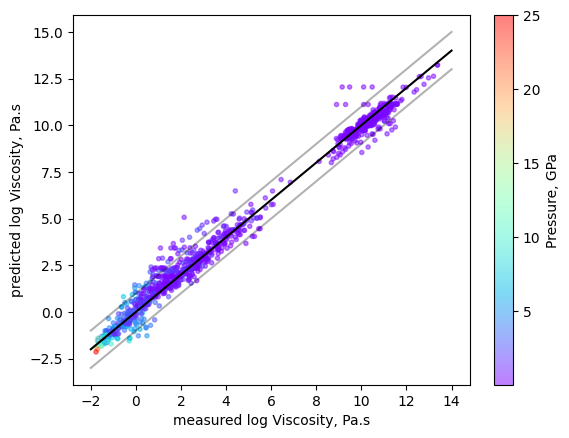

In [33]:
plt.plot([-2,14],[-2,14],'k')
plt.plot([-2,14],[-3,13],'k',alpha=0.3)
plt.plot([-2,14],[-1,15],'k',alpha=0.3)
plt.scatter(dataset_hp.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_ivisc.detach().numpy(),
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            alpha = 0.5
           )
plt.xlabel('measured log Viscosity, Pa.s')
plt.ylabel('predicted log Viscosity, Pa.s')
plt.colorbar(label='Pressure, GPa')